In [2]:
import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.animation as animation
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from scipy.ndimage import gaussian_filter

import genjax
from genjax import ChoiceMapBuilder as C
from genjax import Pytree, gen, pretty
from genjax._src.generative_functions.distributions.distribution import Distribution
from genjax.typing import FloatArray, PRNGKey

pretty()
key = jax.random.PRNGKey(0)

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
matplotlib.rcParams["animation.embed_limit"] = 25

Here's a simple image representing a black and white version of the GenJAX logo.

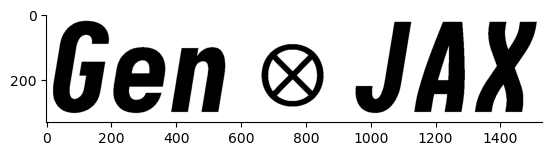

In [3]:
# # Load the image
im = mpimg.imread("./logo.png")

# Convert to mask
im = np.amax(im[:, :, :2], 2) < 0.9
# invert the image
im = np.logical_not(im)

# Convert back to float
im = im.astype(float)
height, width = im.shape
# plot the image
plt.imshow(im, cmap="gray")
plt.show()

We can see this as a uniform distribution on the black part of the image. 
Let's write a GenJAX model that captures this idea.

In [4]:
# Define the model that generated the image
# We'll have an optional blurring parameter that we'll anneal from 0 to 1.
@Pytree.dataclass
class Logo(Distribution):
    image: FloatArray = Pytree.static()
    threshold: FloatArray = Pytree.static(default=1e2)
    use_blurred_image: bool = Pytree.static(default=False)
    likelihood_multiplier: FloatArray = Pytree.static(default=20.0)
    blurring_sigma: FloatArray = Pytree.static(default=50.0)

    def log_likelihood(self, x, y, height, width, temperature: FloatArray):
        if self.use_blurred_image:
            # TODO: sort the weird bug that happens here
            blurred_image = jnp.array(
                gaussian_filter(
                    self.image, sigma=self.blurring_sigma * (1.0 - temperature)
                )
            )
        else:
            blurred_image = self.image

        floor_x, floor_y = jnp.floor(x), jnp.floor(y)
        floor_x, floor_y = (
            jnp.astype(floor_x, jnp.int32),
            jnp.astype(floor_y, jnp.int32),
        )
        out_of_bounds = (
            (floor_x < 0) | (floor_x >= width) | (floor_y < 0) | (floor_y >= height)
        )
        value = jax.lax.cond(
            out_of_bounds,
            lambda *_: -self.threshold,
            lambda arg: temperature
            * self.likelihood_multiplier
            * (1.0 - blurred_image[arg[1], arg[0]])
            - jnp.log(height * width) * (1.0 - temperature),
            operand=(floor_x, floor_y),
        )
        return value

    # The logo easily defines a density but we can't easily sample from it.
    # Fortunately, we won't need to, but we need to implement something to
    # satisfy the interface.
    # In the future, we should have a generalization of `Distribution` that
    # only need to support estimating logpdf.
    def random_weighted(self, key: PRNGKey, height, width, temperature: FloatArray):
        key, subkey = jax.random.split(key)
        x = jax.random.uniform(key, minval=0, maxval=width)
        y = jax.random.uniform(subkey, minval=0, maxval=height)
        logpdf = self.log_likelihood(x, y, height, width, temperature)
        return -logpdf, (x, y)

    def estimate_logpdf(self, key: PRNGKey, z, height, width, temperature: FloatArray):
        x, y = z
        return self.log_likelihood(x, y, height, width, temperature)


im_jax = jnp.array(im.astype(float))
logo = Logo(image=im_jax, use_blurred_image=False)

In [5]:
@gen
def model(height, width, temperature):
    z = logo(height, width, temperature) @ "z"
    return z

Testing

In [6]:
key, subkey = jax.random.split(key)
model.simulate(subkey, (height, width, 0.0))

StaticTrace(
  gen_fn=model,
  args=(330, 1530, 0.0),
  retval=(
    <jax.Array(54.005924, dtype=float32)>,
    <jax.Array(201.01318, dtype=float32)>,
  ),
  addresses=AddressVisitor(visited=[('z',)]),
  subtraces=[
    DistributionTrace(
      gen_fn=Logo(image=<jax.Array float32(330, 1530) ≈0.68 ±0.47 [≥0.0, ≤1.0] zero:159_689 nonzero:345_211>, threshold=100.0, use_blurred_image=False, likelihood_multiplier=20.0, blurring_sigma=50.0),
      args=(330, 1530, 0.0),
      value=(<jax.Array(54.005924, dtype=float32)>, <jax.Array(201.01318, dtype=float32)>),
      score=<jax.Array(13.132115, dtype=float32)>,
    ),
  ],
  score=<jax.Array(13.132115, dtype=float32)>,
)

Now for inference, we will use SMC with a variety of custom proposals. Each intermediate target will be an annealed version of the posterior. We will start from a "high temperature" which we can think of as a more diffuse distribution for which it'll be easier for particles to find a region of decent likelihood, and progressively cool down the process by using smaller temperature parameters in the intermediate targets.

Let's define the initial proposal:

In [7]:
@genjax.gen
def sub_proposal():
    x = genjax.uniform(0.0, float(width)) @ "x"
    y = genjax.uniform(0.0, float(height)) @ "y"
    return x, y


@genjax.gen
def init_proposal():
    z = sub_proposal() @ "z"
    return z

Testing

In [8]:
key, subkey = jax.random.split(key)
jitted_init_proposal = jax.jit(lambda x: init_proposal.simulate(x, ()))
jitted_init_proposal(subkey).get_sample()["z", "x"]

<jax.Array(1270.1399, dtype=float32)>

From just this basic proposal, we can test SIR.

In [9]:
jitted_model = jax.jit(model.importance)
num_particles = 10000


def run_sir(key, num_particles, temperature):
    key, subkey = jax.random.split(key)
    keys = jax.random.split(subkey, num_particles)
    trs = jax.vmap(jitted_init_proposal)(keys)
    sampled_z = jax.vmap(
        lambda x: (x.get_choices()["z", "x"], x.get_choices()["z", "y"])
    )(trs)
    proposal_scores = jax.vmap(lambda x: x.get_score())(trs)
    # key is not actually used in jitted_model
    key, subkey = jax.random.split(key)
    _, model_scores = jax.jit(
        jax.vmap(
            lambda x: jitted_model(subkey, C["z"].set(x), (height, width, temperature))
        )
    )(sampled_z)
    importance_scores = model_scores - proposal_scores
    key, subkey = jax.random.split(key)
    resampled_indices = jax.random.categorical(
        subkey, importance_scores, shape=(num_particles,)
    )
    sampled_x, sampled_y = sampled_z
    resampled_x = sampled_x[resampled_indices]
    resampled_y = sampled_y[resampled_indices]

    return sampled_z, resampled_x, resampled_y

In [10]:
# Initial high temperature: the model is uniform
key, subkey = jax.random.split(key)
sampled_z, ht_resampled_x, ht_resampled_y = run_sir(key, num_particles, 0.0)
sampled_x, sampled_y = sampled_z

# Final low temperature: the model is the posterior
key, subkey = jax.random.split(key)
sampled_z, lt_resampled_x, lt_resampled_y = run_sir(key, num_particles, 1.0)

Plotting the results

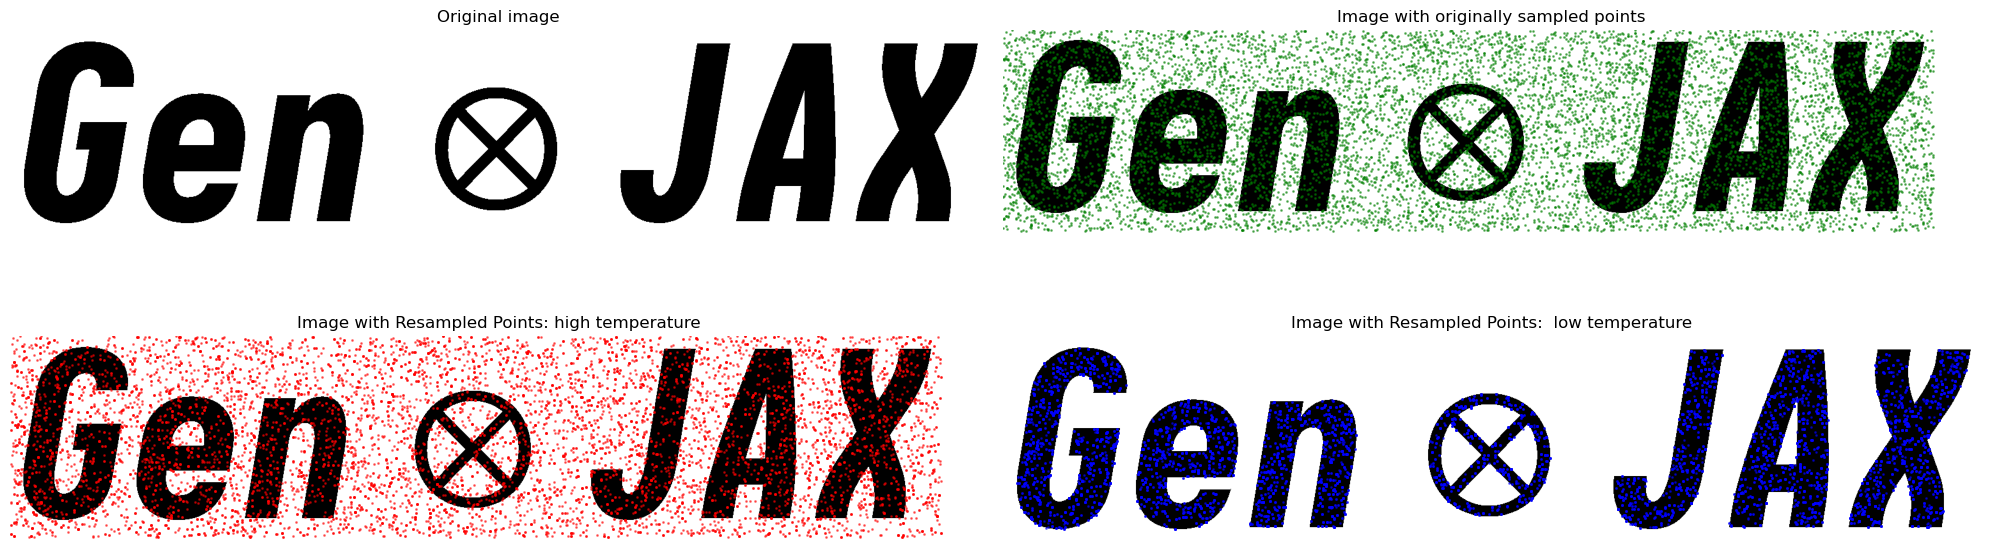

In [11]:
# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 7))


# Plot 1: Original image
ax1.imshow(im, cmap="gray")
ax1.set_title("Original image")
ax1.axis("off")

# Plot 2: Image with originally sampled points
ax2.imshow(im, cmap="gray")
ax2.scatter(sampled_x, sampled_y, c="green", s=1, alpha=0.5)
ax2.set_title("Image with originally sampled points")
ax2.axis("off")


# Plot 3: Image with resampled Points: high temperature
ax3.imshow(im, cmap="gray")
ax3.scatter(ht_resampled_x, ht_resampled_y, c="red", s=1, alpha=0.5)
ax3.set_title("Image with Resampled Points: high temperature")
ax3.axis("off")


# Plot 4: Image with resampled Points: low temperature
ax4.imshow(im, cmap="gray")
ax4.scatter(lt_resampled_x, lt_resampled_y, c="blue", s=1, alpha=0.5)
ax4.set_title("Image with Resampled Points:  low temperature")
ax4.axis("off")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Let's try a few intermediate stages between the high and low temperatures.

In [12]:
number_steps = 20
num_particles = 10000


def run_initial_particles(key, num_particles):
    key, subkey = jax.random.split(key)
    keys = jax.random.split(subkey, num_particles)
    trs = jax.vmap(jitted_init_proposal)(keys)
    sampled_z = jax.vmap(
        lambda x: (x.get_choices()["z", "x"], x.get_choices()["z", "y"])
    )(trs)
    proposal_scores = jax.vmap(lambda x: x.get_score())(trs)
    return sampled_z, proposal_scores


def is_step(key, sampled_z, proposal_scores, temperature):
    key, subkey = jax.random.split(key)
    _, model_scores = jax.vmap(
        lambda x: model.importance(subkey, C["z"].set(x), (height, width, temperature))
    )(sampled_z)
    importance_scores = model_scores - proposal_scores
    key, subkey = jax.random.split(key)
    resampled_indices = jax.random.categorical(
        subkey, importance_scores, shape=(num_particles,)
    )
    sampled_x, sampled_y = sampled_z
    resampled_x = sampled_x[resampled_indices]
    resampled_y = sampled_y[resampled_indices]
    return resampled_x, resampled_y


def run_all_is(key, num_particles, number_steps):
    sampled_z, proposal_scores = jax.jit(run_initial_particles, static_argnums=(1,))(
        key, num_particles
    )
    jitted_is_step = jax.jit(is_step)

    def body(carry, tmp):
        key, subkey = jax.random.split(carry)
        sampled_x, sampled_y = jitted_is_step(
            subkey, sampled_z, proposal_scores, tmp**2
        )
        return key, (sampled_x, sampled_y)

    carry_init = key
    _, (all_sampled_x, all_sampled_y) = jax.lax.scan(
        body, carry_init, jnp.arange(0.0, 1.0 + 1.0 / number_steps, 1.0 / number_steps)
    )
    return all_sampled_x, all_sampled_y


key, subkey = jax.random.split(key)
all_sampled_x, all_sampled_y = jax.jit(run_all_is, static_argnums=(1, 2))(
    key, num_particles, number_steps
)

# TODO: somehow compute time is way too slow.
all_sampled_x.min(), all_sampled_x.max(), all_sampled_y.min(), all_sampled_y.max()

(<jax.Array(0.01367927, dtype=float32)>,
 <jax.Array(1529.8937, dtype=float32)>,
 <jax.Array(0.03847361, dtype=float32)>,
 <jax.Array(329.96777, dtype=float32)>)

Which we can visualize:

In [13]:
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(8, 2))
images = []


scatter_plots = [
    ax.scatter(all_sampled_x[i], height - all_sampled_y[i], c="white", s=1, alpha=0.5)
    for i in range(0, number_steps + 1)
]

for i in range(0, number_steps + 1):
    scatter = scatter_plots[i]
    title = ax.text(
        0.5,
        1.05,
        f"Temperature: {i / number_steps:.1f}",
        ha="center",
        va="center",
        transform=ax.transAxes,
        fontsize=12,
        color="white",
    )
    images.append([scatter, title])

ani = animation.ArtistAnimation(fig, images, interval=200, blit=True, repeat_delay=1000)

# Save the animation as a GIF & display the animation in the notebook
ani.save("initial_IS_animation.gif", writer="pillow")
HTML(ani.to_jshtml())

Let's now evolve the particles over time using SMC. We will use a few different proposal distributions to visualize how the particles evolve.

In [14]:
# v1: random wiggling proposal
@genjax.gen
def proposal1(x, y):
    x = genjax.normal(x, 1.0 * min(height, width) / 10) @ "x"
    y = genjax.normal(y, 1.0 * min(height, width) / 10) @ "y"
    return x, y


# v2: rotating proposal distribution
@genjax.gen
def proposal2(x, y):
    theta = 0.15
    center_x, center_y = width / 2, height / 2
    aspect_ratio = height / width
    x_scaled = (x - center_x) * aspect_ratio
    y_scaled = y - center_y
    x_rotated = x_scaled * jnp.cos(theta) - y_scaled * jnp.sin(theta)
    y_rotated = x_scaled * jnp.sin(theta) + y_scaled * jnp.cos(theta) + center_y
    x_rotated = x_rotated / aspect_ratio + center_x

    x = genjax.normal(x_rotated, 1.0 * min(height, width) / 10) @ "x"
    y = genjax.normal(y_rotated, 1.0 * min(height, width) / 10) @ "y"
    return x, y


# v3: spiraling inwards proposal distribution
@genjax.gen
def proposal3(x, y):
    inward_coeff = 0.9
    theta = 0.15
    center_x, center_y = width / 2, height / 2
    aspect_ratio = height / width
    x_scaled = (x - center_x) * aspect_ratio
    y_scaled = y - center_y
    x_rotated = (x_scaled * jnp.cos(theta) - y_scaled * jnp.sin(theta)) * inward_coeff
    y_rotated = x_scaled * jnp.sin(theta) + y_scaled * jnp.cos(theta) + center_y
    x_rotated = (x_rotated / aspect_ratio + center_x) * inward_coeff

    x = genjax.normal(x_rotated, 1.0 * min(height, width) / 10) @ "x"
    y = genjax.normal(y_rotated, 1.0 * min(height, width) / 10) @ "y"
    return x, y

In [15]:
number_steps = 30
num_particles = 5000


# resample `out_particles` particles from the particles `sampled_z` according to `weights`
def resample(key, weights, sampled_z, out_particles):
    resampled_indices = jax.random.categorical(key, weights, shape=(out_particles,))
    sampled_x, sampled_y = sampled_z
    resampled_x = sampled_x[resampled_indices]
    resampled_y = sampled_y[resampled_indices]
    return (resampled_x, resampled_y), (
        jax.scipy.special.logsumexp(weights) - jnp.log(len(weights))
    ) * jnp.ones(out_particles)


# return the original particles and weights if the criterion is not met, and resample the particles and return the average weight otherwise
def maybe_resample(key, weights, sampled_z, out_particles, criterion):
    return jax.lax.cond(
        criterion,
        lambda: resample(key, weights, sampled_z, out_particles),
        lambda: (sampled_z, weights),
    )


def smc_step(key, sampled_z, weights, num_particles, temperature):
    key, subkey = jax.random.split(key)
    keys = jax.random.split(subkey, num_particles)
    trs = jax.vmap(proposal1.simulate, in_axes=(0, 0))(keys, (sampled_z))
    sampled_z = jax.vmap(lambda x: (x.get_choices()["x"], x.get_choices()["y"]))(trs)
    proposal_scores = jax.vmap(lambda x: x.get_score())(trs)

    key, subkey = jax.random.split(key)
    _, model_scores = jax.vmap(
        lambda x: model.importance(subkey, C["z"].set(x), (height, width, temperature))
    )(sampled_z)
    importance_scores = model_scores - proposal_scores
    weights = weights + importance_scores

    key, subkey = jax.random.split(key)
    criterion = jnp.any(
        jnp.isclose(temperature, jnp.array([0.2, 0.4, 0.6, 0.8]), atol=0.01)
    )
    sampled_z, weights = maybe_resample(
        subkey, weights, sampled_z, num_particles, criterion
    )
    return sampled_z, weights


def run_smc(key, num_particles, number_steps):
    sampled_z, proposal_scores = run_initial_particles(key, num_particles)
    # Initial importance weights
    weights = jnp.zeros(num_particles) - proposal_scores

    def body(carry, tmp):
        key, subkey = jax.random.split(carry[0])
        sampled_z, weights = smc_step(subkey, carry[1], carry[2], num_particles, tmp)
        return (key, sampled_z, weights), sampled_z

    carry_init = (key, sampled_z, weights)
    _, (all_sampled_x, all_sampled_y) = jax.lax.scan(
        body, carry_init, jnp.arange(0.0, 1.0 + 1.0 / number_steps, 1.0 / number_steps)
    )
    return all_sampled_x, all_sampled_y


key, subkey = jax.random.split(key)
all_sampled_x, all_sampled_y = jax.jit(run_smc, static_argnums=(1, 2))(
    key, num_particles, number_steps
)

all_sampled_x.min(), all_sampled_x.max(), all_sampled_y.min(), all_sampled_y.max()

(<jax.Array(-211.00313, dtype=float32)>,
 <jax.Array(1752.5132, dtype=float32)>,
 <jax.Array(-248.33366, dtype=float32)>,
 <jax.Array(680.62354, dtype=float32)>)

Visualizing what we got!

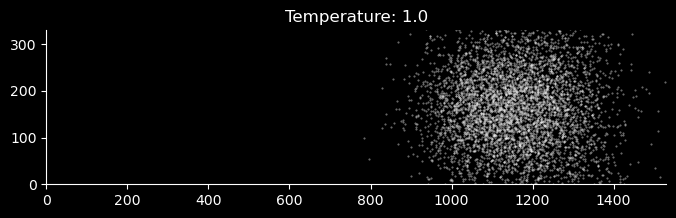

In [16]:
fig, ax = plt.subplots(figsize=(8, 2))
images = []

plt.style.use("dark_background")
animation.embed_limit = 25

# Initialize scatter plot
scatter = ax.scatter([], [], c="black", s=1000 * 1 / num_particles, alpha=0.5)

ax.set_xlim(0, width)
ax.set_ylim(0, height)


def update(frame):
    scatter.set_offsets(
        np.c_[all_sampled_x[frame], height - all_sampled_y[frame]]
    )  # Corrected to flip the y-axis
    scatter.set_facecolor("white")  # Set color to white throughout the animation
    ax.set_title(f"Temperature: {frame / number_steps:.1f}")
    return (scatter,)


ani = animation.FuncAnimation(
    fig, update, frames=number_steps + 1, interval=100, blit=True, repeat_delay=10000
)

# Save the animation as a GIF & display the animation in the notebook
ani.save("SMC_animation.gif", writer="pillow")
HTML(ani.to_jshtml())

We now try rejuvenation. We will use the same proposal kernels as before, but this time they will be used differently.
We will also try different rejuvenation methods that strike a balance between compute and variance.

In [17]:
# not sure how to do a non-hacky thing for now
key, unused_key = jax.random.split(key)


def proposal_scorer(x, y):
    return proposal1.importance(unused_key, C["x"].set(x[0]) ^ C["y"].set(x[1]), y)


def final_model_scorer(x):
    return jitted_model(unused_key, C["z"].set(x), (height, width, 1.0))


# v1: random wiggling proposal
@genjax.gen
def boltzman_rejuv(x, y):
    mb_x, mb_y = proposal1(x, y) @ "mb"
    _, p_old_z = final_model_scorer((x, y))
    _, backward_score = proposal_scorer((x, y), (mb_x, mb_y))
    _, p_new_z = final_model_scorer((mb_x, mb_y))
    _, forward_score = proposal_scorer((mb_x, mb_y), (x, y))
    move_score = p_new_z + forward_score - backward_score
    stay_score = p_old_z
    i = genjax.categorical(jnp.array([stay_score, move_score])) @ "i"
    return jax.lax.cond(i == 0, lambda: (x, y), lambda: (mb_x, mb_y))


# v2: bolzman rejuv with more random moves
@genjax.gen
def boltzman_rejuv_many_trials(x, y, num_moves):
    mb_zs = proposal1.repeat(n=num_moves.unwrap())(x, y) @ "mb"
    _, p_old_z = final_model_scorer((x, y))
    _, p_new_zs = jax.vmap(final_model_scorer)(mb_zs)
    _, backward_scores = jax.vmap(proposal_scorer, in_axes=(None, 0))((x, y), mb_zs)
    _, forward_scores = jax.vmap(proposal_scorer, in_axes=(0, None))((mb_zs), (x, y))
    move_scores = p_new_zs + forward_scores - backward_scores
    stay_score = p_old_z
    i = (
        genjax.categorical(jnp.concatenate([jnp.array([stay_score]), move_scores]))
        @ "i"
    )
    mb_xs, mb_ys = mb_zs
    return jax.lax.cond(i == 0, lambda: (x, y), lambda: (mb_xs[i - 1], mb_ys[i - 1]))


# Test the v1 rejuvenation process
key, subkey = jax.random.split(key)
x, y = (0.5, 0.5)
tr = boltzman_rejuv.simulate(subkey, (x, y))
tr.get_retval()

# Test the v2 rejuvenation process
key, subkey = jax.random.split(key)
x, y = (0.5, 0.5)
tr = boltzman_rejuv_many_trials.simulate(subkey, (x, y, Pytree.const(10)))
tr.get_retval()

(<jax.Array(0.5, dtype=float32)>, <jax.Array(0.5, dtype=float32)>)

In [18]:
number_steps = 30
num_particles = 2500
num_moves = Pytree.const(10)

# jitted_boltzman_rejuv = jax.jit(jax.vmap(boltzman_rejuv.simulate, in_axes=(0, 0)))

jitted_boltzman_rejuv_many_trials = jax.jit(
    jax.vmap(
        lambda key, x, y, num_moves: boltzman_rejuv_many_trials.simulate(
            key, (x, y, num_moves)
        ),
        in_axes=(0, 0, 0, None),
    )
)

rejuv_all_sampled_x = []
rejuv_all_sampled_y = []

# samples and scores from proposal
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num_particles)
trs = jax.vmap(jitted_init_proposal)(keys)
sampled_z = jax.vmap(lambda x: (x.get_choices()["z", "x"], x.get_choices()["z", "y"]))(
    trs
)
sampled_x, sampled_y = sampled_z

# adding initial state
rejuv_all_sampled_x.append(sampled_x)
rejuv_all_sampled_y.append(sampled_y)

# assuming initial state is resampled_z, we can run rejuvenation several times and see how it evolves
for tmp in jnp.arange(0.0, 1.0 + 1.0 / number_steps, 1.0 / number_steps):
    # samples and scores from proposal kernels using the chm from previous step
    key, subkey = jax.random.split(key)
    keys = jax.random.split(subkey, num_particles)
    # trs = jitted_boltzman_rejuv(keys, sampled_z)
    trs = jitted_boltzman_rejuv_many_trials(keys, sampled_x, sampled_y, num_moves)
    sampled_z = jax.jit(jax.vmap(lambda x: x.get_retval()))(trs)
    sampled_x, sampled_y = sampled_z
    # store results for later visualization
    rejuv_all_sampled_x.append(sampled_x)
    rejuv_all_sampled_y.append(sampled_y)

Plotting the rejuvenated particles.

In [19]:
fig, ax = plt.subplots(figsize=(8, 2))

plt.style.use("dark_background")

# Initialize scatter plot
scatter = ax.scatter([], [], c="red", s=1000 * 1 / num_particles, alpha=0.5)

ax.set_xlim(0, width)
ax.set_ylim(0, height)


def update(frame):
    scatter.set_offsets(
        np.c_[rejuv_all_sampled_x[frame], height - rejuv_all_sampled_y[frame]]
    )  # Corrected to flip the y-axis
    scatter.set_facecolor("white")
    ax.set_title(f"Temperature: {frame / number_steps:.1f}")
    return (scatter,)


ani = animation.FuncAnimation(
    fig, update, frames=number_steps + 1, interval=100, blit=True, repeat_delay=10000
)

# Save the animation as a GIF & display the animation in the notebook
ani.save("SMC_animation.gif", writer="pillow")
HTML(ani.to_jshtml())

Technically, we could resample here but it'd be bad idea as the particles are already quite good but the particles weights don't represent this fact. This is why seeing rejuvenation as an SMCP3 move with a different backward proposal which does update the particles is better.

Let's try it to see how the quality deteriorates.

In [20]:
proposal_scores = jax.vmap(lambda x: x.get_score())(trs)
initial_traces = trs  # traces from the uniform proposal before any rejuvenation
final_sampled_z = sampled_z  # samples from the uniform proposal after rejuvenation

# scores from posterior model
key, subkey = jax.random.split(key)
_, model_scores = jax.vmap(
    lambda x: jitted_model(subkey, C["z"].set(x), (height, width, 1.0))
)(final_sampled_z)

# importance scores and resampling
importance_scores = model_scores - proposal_scores
key, subkey = jax.random.split(key)
resampled_indices = jax.random.categorical(
    subkey, importance_scores, shape=(num_particles,)
)
sampled_x, sampled_y = final_sampled_z
resampled_x = sampled_x[resampled_indices]
resampled_y = sampled_y[resampled_indices]

Plotting the results

In [21]:
# animate the last 2 set of particles
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(20, 7))
# Plot 1: Original image
ax1.scatter(sampled_x, height - sampled_y, c="white", s=1, alpha=1)
ax1.set_title("Sampled points")
ax1.axis("off")

# Plot 2: Image with originally sampled points
ax2.scatter(resampled_x, height - resampled_y, c="white", s=1, alpha=1)
ax2.set_title("Resampled points")
ax2.axis("off")

(-19.547543334960935, 1570.4357879638671, 21.97597961425781, 320.9908782958984)

What we can do instead is to to update the particles weights. 
We can do this simply by adding another simple kernel, update the weights appropriately and then resample.

Let's try it.

In [1]:
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num_particles)


@genjax.gen
def proposal4(x, y):
    x = genjax.normal(x, 1.0 * min(height, width) / 50) @ "x"
    y = genjax.normal(y, 1.0 * min(height, width) / 50) @ "y"
    return x, y


new_trs = jax.vmap(proposal4.simulate)(keys, (sampled_z))

# old proposal scores
old_proposal_scores = jax.jit(jax.vmap(lambda x: x.get_score()))(trs)

# new samples
new_sampled_z = jax.jit(
    jax.vmap(lambda x: (x.get_choices()["x"], x.get_choices()["y"]))
)(new_trs)
# new proposal scores
new_proposal_scores = jax.jit(jax.vmap(lambda x: x.get_score()))(new_trs)

# old model scores
key, subkey = jax.random.split(key)
_, old_model_scores = jax.jit(
    jax.vmap(lambda x: jitted_model(subkey, C["z"].set(x), (height, width, 1.0)))
)(sampled_z)
# new model scores
key, subkey = jax.random.split(key)
_, new_model_scores = jax.jit(
    jax.vmap(lambda x: jitted_model(subkey, C["z"].set(x), (height, width, 1.0)))
)(new_sampled_z)

# SMCP3 weights
importance_scores = (
    new_model_scores - old_model_scores + old_proposal_scores - new_proposal_scores
)

# resampling
key, subkey = jax.random.split(key)
resampled_indices = jax.random.categorical(
    subkey, importance_scores, shape=(num_particles,)
)
new_sampled_x, new_sampled_y = new_sampled_z
new_resampled_x = new_sampled_x[resampled_indices]
new_resampled_y = new_sampled_y[resampled_indices]

NameError: name 'jax' is not defined

Generating '/var/tmp/nsys-report-2d2c.qdstrm'
[1/1] [========================100%] smc_custom_proposal_2024-11-03T13:17:26.nsys-rep
Generated:
    /home/eighty/nsight-profiling/src/nsight_profiling/genjax/notebooks/smc_custom_proposal_2024-11-03T13:17:26.nsys-rep


Plotting the better resampled particles and comparing with the previous ones.


(-32.543779373168945,
 1571.4368991851807,
 19.27507629394531,
 322.01026306152346)

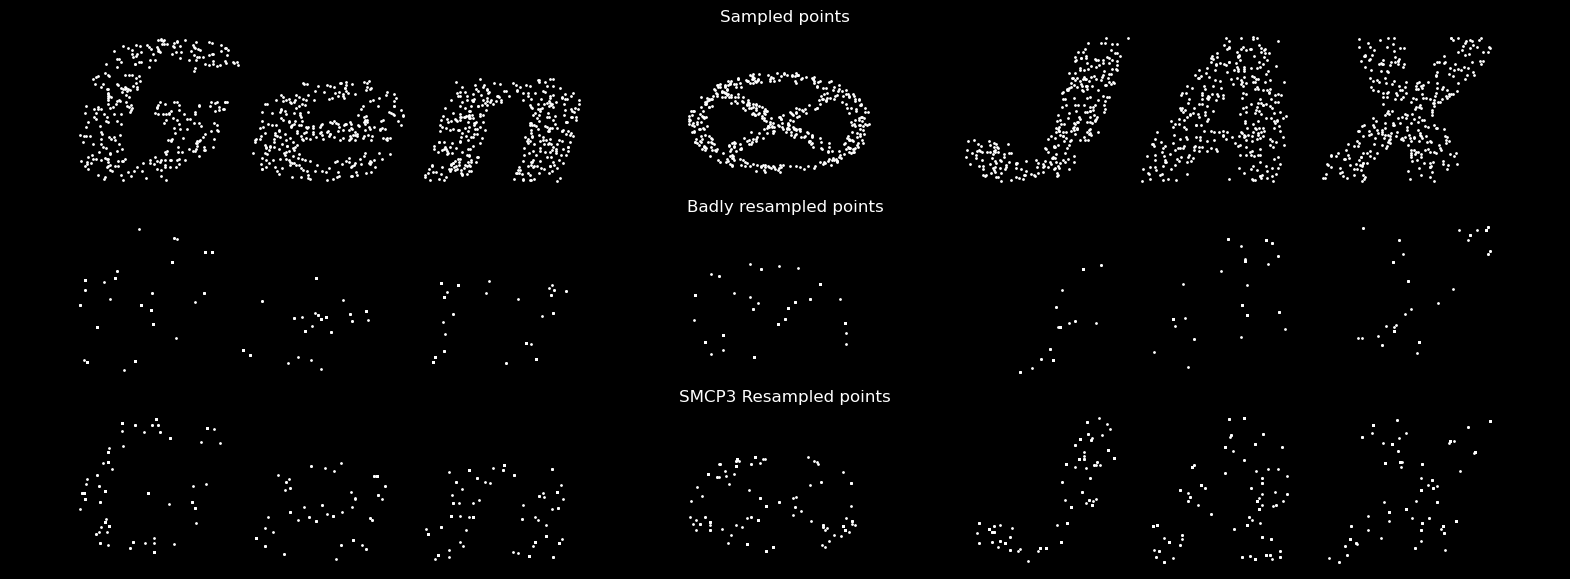

In [23]:
fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(20, 7))
# Plot 1: Before resampling
# ax1.imshow(im, cmap="gray")
ax1.scatter(sampled_x, height - sampled_y, c="white", s=1, alpha=1)
ax1.set_title("Sampled points")
ax1.axis("off")

# Plot 2: After resampling with bad weights
# ax1.imshow(im, cmap="gray")
ax2.scatter(resampled_x, height - resampled_y, c="white", s=1, alpha=1)
ax2.set_title("Badly resampled points")
ax2.axis("off")

# Plot 2: After resampling with SMCP3 move
# ax2.imshow(im, cmap="gray")
ax3.scatter(new_resampled_x, height - new_resampled_y, c="white", s=1, alpha=1)
ax3.set_title("SMCP3 Resampled points")
ax3.axis("off")

We now test some more complicated rejuvenation schemes.

We start with a grid rejuvenation scheme.

In [24]:
# v3: grid proposal
def create_grid(center, grid_size, spacing):
    x, y = center
    # half_size = grid_size // 2
    spacing = 1.0
    half_size = 10 // 2
    x_values = x + jnp.arange(
        -half_size * spacing, (half_size + 1) * spacing, spacing, dtype=jnp.float32
    )
    y_values = y + jnp.arange(
        -half_size * spacing, (half_size + 1) * spacing, spacing, dtype=jnp.float32
    )
    grid = jnp.array(jnp.meshgrid(x_values, y_values)).T.reshape(-1, 2)
    return grid


print(create_grid((0.5, 0.5), 10, 1.0).shape)
grid_points = create_grid((0.5, 0.5), 10, 1.0)
scores = jax.vmap(final_model_scorer)(grid_points)

# _, model_scores = jax.vmap(lambda x :final_model_scorer(x))(grid_points)


def inverse_grid_index(grid_n_points, j):
    return jnp.ravel_multi_index(jnp.array(grid_n_points) + 1 - j, grid_n_points)


# @partial(jax.jit, static_argnums=(2, 3))
# @genjax.gen
# def grid_rejuv(x, y, grid_size=Pytree.const(10), spacing=Pytree.const(1.0)):
#     grid_points = create_grid((x, y), grid_size.unwrap(), spacing.unwrap())
#     # grid_points_x, grid_points_y = grid_points
#     _, model_scores = jax.vmap(final_model_scorer)(grid_points)
#     resampled_index = jax.random.categorical(key, model_scores)
#     backward_index = inverse_grid_index(grid_points, resampled_index)
#     # TODO: need to compute the backward score, which is the pdf of a categorical rv with args the model scores at the grid points centred on the proposed point
#     return grid_points[resampled_index]


# # Test the v3 rejuvenation process
# key, subkey = jax.random.split(key)
# x, y = (0.5, 0.5)
# tr = grid_rejuv.simulate(subkey, (x, y))
# x= tr.get_retval()
# print(x)

(121, 2)


ValueError: safe_map() argument 2 is shorter than argument 1

Now we can add a circular mask for the initial proposal.

In [ ]:
# We need a mask on the image, independent of the inference
# for inference, what we want is a proposal clipped to the mask, which doesn't use masking
# a proper way would be to use meta-inference, but we can just have exponentially decaying probabilities outside the disk, and hope for the best

In [ ]:
# Desired interactions:
# - mask disk centred around mouse cursor. truncated to borders of the image
# - mouse scroll: change radius of mask between 10 and 100 pixel
# - left click: higher temperature (max exp^0)
# - right click: lower temperature (min exp^{-1})
# - SMC running while all of this is happening.
# - may want yet another way to change the number of particles: with 1000 it's hard to see the logo but with 10k it's obvious.
# - the rejuv dynamics could be guided by the mouse cursor moving. so that we can have particle move and bump more against the letters which a human can infer.
# - we could infer the dynamics of the cursor between linear, quadratic, etc. by deterministic regression and propose dynamics according to the chosen one.
